In [166]:
import pandas as pd
import plotnine as p9
import numpy as np

data = pd.read_csv("./test/database/treatment.csv",
                   sep = "\t")

In [181]:
from datetime import datetime as dt
from datetime import timedelta as td

class Antibiotic:


    def __init__(self, info):

        self.name = info[0].capitalize()
        self.activity = info[2].upper() if info[2] != "nan" else ""
        self.start = info[4]
        self.end = info[5]

        self.reformatDate()
        self.reformatActivity()


    def reformatActivity(self):

        if self.activity:

            if self.activity in ["I", "S", "NR", "SUSC", "SUSCEPTIBLE", "SUSCPETIBLE"]:
                self.activity = "S"

            elif self.activity == "R":
                pass

            else:
                print(self.activity)
                raise ValueError

        else: self.activity = "S"

    def reformatDate(self):

        if "-" in self.start:
            self.start = dt.strptime(self.start, "%Y-%m-%d")
        elif "/" in self.start:
            self.start = dt.strptime(self.start, "%d/%m/%Y")

        if "-" in self.end:
            self.end = dt.strptime(self.end, "%Y-%m-%d")
        elif "/" in self.end:
            self.end = dt.strptime(self.end, "%d/%m/%Y")

        self.duration = (self.end - self.start).days + 1

    def __str__(self):

        return f"{self.name}: {self.activity}\n\t{self.start} -> {self.end}"

    def __repr__(self) -> str:

        return str(self)



class Patient:


    def __init__(self, info):

        self.extractInfo(info)


    def extractInfo(self, info):


        for column in info.index:
            value = info[column]

            if "ATB" not in column: setattr(self, column.lower(), value.lower() if isinstance(value, str) else value)


        columns = info.index[18:]

        self.treatment = []
        for index, column in enumerate(columns[::7]):

            antibioticInfo = [f"{info[aux]}" for aux in columns[index * 7 : index * 7 + 7]]

            if antibioticInfo[0] != "nan":
                self.treatment.append(Antibiotic(antibioticInfo))


    @property
    def dates(self):

        dates = []

        for atb in self.treatment:
            dates.append(atb.start)
            dates.append(atb.end)

        dates.sort()

        return dates


    @property
    def firstDay(self): return self.dates[0]


    @property
    def lastDay(self): return self.dates[-1]


    @property
    def treatmentDuration(self): return (self.lastDay - self.firstDay).days + 1


    @property
    def treatmentLine(self):

        timeline = []
        for index, date in enumerate((self.firstDay + td(n) for n in range(self.treatmentDuration))):

            for atb in self.treatment:

                if atb.start <= date <= atb.end:

                    try:
                        timeline[index].add(f"{atb.name}_{atb.activity}")
                    except IndexError:
                        timeline.append({f"{atb.name}_{atb.activity}"})

        return timeline[:30]

    @property
    def activeTreatmentLine(self):

        timeline = []

        for step in self.treatmentLine:
            aux = set()

            for atb in step:
                if atb[-2:] == "_R": aux.add("Inactive")
                else: aux.add(atb[:-2])

            timeline.append(aux)

        return timeline


    @property
    def condensedTreatmentLine(self):

        timeline = []

        for date in self.treatmentLine:

            try:
                if date != timeline[-1]:
                    timeline.append(date)

            except IndexError:
                timeline.append(date)

        return timeline


    @property
    def changesTratmentLine(self):

        timeline = []

        for date in self.condensedTreatmentLine:

            aux = set()

            for atb in date:
                if "_R" in atb: aux.add("Inactive")
                else: aux.add(atb[:-2])

            timeline.append(aux)

        return timeline

    @property
    def allTreatment(self):

        aux = set()
        for step in self.changesTratmentLine:
            for atb in step:
                aux.add(atb)

        return aux




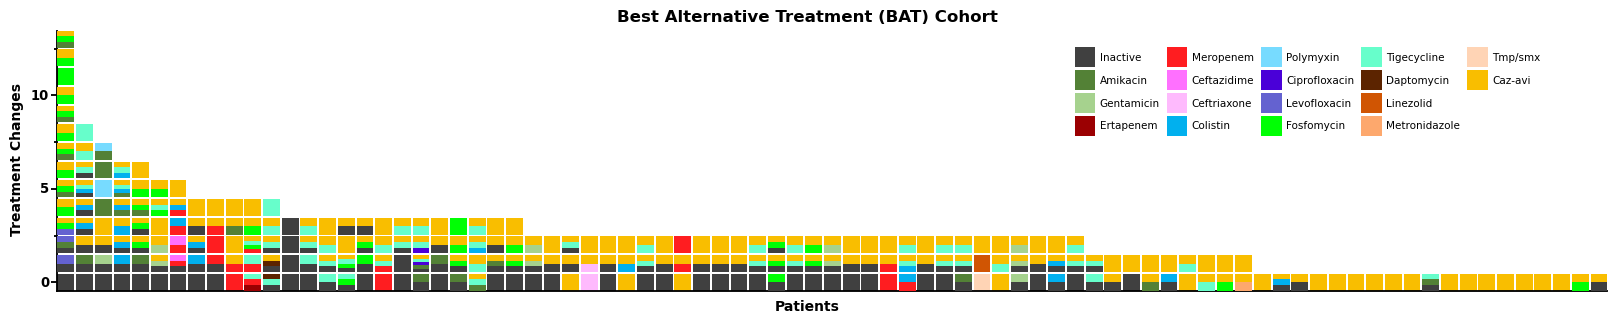

<ggplot: (8745416725884)>

In [233]:
import pandas as pd
import plotnine as p9
import numpy as np
from datetime import datetime, timedelta
from plotnine import *
from plotnine_prism import *

def generatePlot(info, width = 0.9, height = 0.9):

    mask = {"Caz-avi"               : "zCaz-avi", # CAZAVI   amarrillo
            "Inactive"              : "aInactive", # Inactivo gris
            "Amikacin"              : "bAmikacin", # Aminoglicosidos verde
            "Gentamicin"            : "bGentamicin", # Aminoglicosidos verde
            "Meropenem"             : "cMeropenem", # Carbapenemicos rojo
            "Ertapenem"             : "cErtapenem", # Carbapenemicos rojo
            "Cefixime"              : "dCefixime", # Cefalosporinas rosa
            "Ceftazidime"           : "dCeftazidime", # Cefalosporinas rosa
            "Ceftriaxone"           : "dCeftriaxone", # Cefalosporinas rosa
            "Colistin"              : "eColistin", # Polimixinas
            "Polymyxin"             : "ePolymyxin", # Polimixinas
            "Ciprofloxacin"         : "fCiprofloxacin", # Quinolonas burdeos
            "Levofloxacin"          : "fLevofloxacin", # Quinolonas burdeos
            "Fosfomycin"            : "gFosfomycin", # Sin grupo (grande) morado
            "Tigecycline"           : "gTigecycline", # Sin grupo (grande) morado
            "Tmp/smx"               : "hTmp/smx", # Sin grupo (pequeño) marrón
            "Meropenem-varbobactam" : "hMeropenem-varbobactam", # Sin grupo (pequeño) marrón
            "Metronidazole"         : "hMetronidazole", # Sin grupo (pequeño) marrón
            "Daptomycin"            : "hDaptomycin", # Sin grupo (pequeño) marrón
            "Linezolid"             : "hLinezolid"  # Sin grupo (pequeño) marrón
            }

    palette = {"zCaz-avi"               : "#f9be00", # CAZAVI   amarrillo
               "aInactive"              : "#404040", # Inactivo gris
               "bAmikacin"              : "#538136", # Aminoglicosidos verde
               "bGentamicin"            : "#a6d28e", # Aminoglicosidos verde
               "cMeropenem"             : "#ff1d20", # Carbapenemicos rojo
               "cErtapenem"             : "#9b0002", # Carbapenemicos rojo
               "dCefixime"              : "#af01b1", # Cefalosporinas rosa
               "dCeftazidime"           : "#ff70ff", # Cefalosporinas rosa
               "dCeftriaxone"           : "#febafd", # Cefalosporinas rosa
               "eColistin"              : "#01b0ee", # Polimixinas azul
               "ePolymyxin"             : "#77dbff", # Polimixinas azul
               "fCiprofloxacin"         : "#4a00d8", # Quinolonas burdeos
               "fLevofloxacin"          : "#6462d0", # Quinolonas burdeos
               "gFosfomycin"            : "#00ff04", # Sin grupo (grande) morado
               "gTigecycline"           : "#67fecb", # Sin grupo (grande) morado
               "hTmp/smx"               : "#ffd4b5", # Sin grupo (pequeño) marrón
               "hMeropenem-varbobactam" : "#fd7e25", # Sin grupo (pequeño) marrón
               "hMetronidazole"         : "#fda86d", # Sin grupo (pequeño) marrón
               "hDaptomycin"            : "#5c2400", # Sin grupo (pequeño) marrón
               "hLinezolid"             : "#d05503"  # Sin grupo (pequeño) marrón
               }


    names = list(palette.keys())

    maximum = []

    allAtbs = set()
    for patient in info:
        for step in patient.changesTratmentLine:
            maximum.append(len(step))
            for atb in step:
                allAtbs.add(mask[atb])


    toDel = set()
    for atb in palette:
        if atb not in allAtbs:
            toDel.add(atb)

    for atb in toDel:
        del palette[atb]
        del mask[atb[1:]]

    inverseMask = {mask[i] : i for i in mask}

    maximum = max(maximum)


    buffer = pd.DataFrame({"Pt"   : [0] * len(allAtbs),
                           "Atb"  : [atb for atb in allAtbs],
                           "Step" : [0] * len(allAtbs)})


    res = {}

    for i in range(1, maximum + 1):
        for j in range(i):
            try:
                res[i][j] = pd.DataFrame(columns = ["Pt", "Atb", "Step"])
            except KeyError:
                res[i] = {j : pd.DataFrame(columns = ["Pt", "Atb", "Step"])}


    # Ordena pacientes de menos cambios a más cambios
    info.sort(key = lambda x: len(x.changesTratmentLine), reverse = True)

    for indexPt, patient in enumerate(info):

        for indexStep, step in enumerate(patient.changesTratmentLine):

            step = [mask[atb] for atb in step]
            step.sort(reverse = True)

            for n, atb in enumerate(step):

                if n != 0:

                    primeWidth = height / len(step) * (len(step) - n)

                    floor = indexStep - (height / 2)

                    primeCenter = floor + (primeWidth / 2)

                else:
                    primeCenter = indexStep

                res[len(step)][n].loc[len(res[len(step)][n].index)] = [indexPt,
                                                                       atb,
                                                                       primeCenter]

    plot = ["ggplot(aes('Pt', 'Step'))",
            "aes(fill = 'Atb')",
            "geom_tile(buffer, aes(width = width, height = height))"]



    for i in res:
        for j in res[i]:

            if j == 0:
                plot.append(f"geom_tile(res[{i}][{j}], aes(width = width, height = height))")

            else:
                plot.append(f"geom_tile(res[{i}][{j}], aes(width = width, height = height / {i} * {i - j}))")

    paco = {i : palette[i] for i in sorted(palette)}

    pepe = [inverseMask[i] for i in sorted(palette)]

    plot.append("scale_fill_manual(paco, labels = pepe)")
    plot.append("coord_equal(expand = False)")
    plot.append("theme_prism()")
    plot.append("theme(legend_position = (0.75, 0.7), legend_direction = 'horizontal')")
    plot.append("theme(axis_title_x = element_text('Patient'))")
    plot.append("theme(axis_text_x = element_blank())")
    plot.append("theme(axis_ticks_x = element_blank())")
    plot.append("labs(title = 'Best Alternative Treatment (BAT) Cohort')")
    plot.append("scale_y_continuous(name = 'Treatment Changes')")
    plot.append("scale_x_continuous(name = 'Patients')")
    plot.append("theme(figure_size = (20, 20))")


    return eval(" + ".join(plot))



data = pd.read_csv("./test/database/treatment.csv",
                   sep = "\t")
data = data[data["Cohort_Treatment"] == "yes"]
data = data[data["Cohort_Cazavi"] == "yes"]

patients = []
for index, row in data.iterrows():
    patients.append(Patient(row))

generatePlot(patients)


In [234]:
for patient in patients:
    if "Caz-avi" not in patient.allTreatment:
        print(patient.pt)

13
163


In [202]:
atbs = {}

for patient in patients:
    for atb in patient.allTreatment:
        if atb in atbs:
            atbs[atb] += 1
        else:
            atbs[atb] = 1

print(atbs)

groups = {"Amikacin"    : "Aminoglicosidos",
          "Gentamicin"  : "Aminoglicosidos",
          "Tigecycline" : "Tigecycline",
          "Colistin"    : "Polimixinas",
          "Polymyxin"   : "Polimixinas",
          "Caz-avi"     : "Caz-avi"}


res = {"Days" : {"Total" : {"Aminoglicosidos" : [],
                            "Tigecycline"     : [],
                            "Polimixinas"     : [],
                            "Caz-avi"         : []},
                 "Prev" : {"Aminoglicosidos" : [],
                           "Tigecycline"     : [],
                           "Polimixinas"     : [],
                           "Caz-avi"         : []},
                 "Post" : {"Aminoglicosidos" : [],
                           "Tigecycline"     : [],
                           "Polimixinas"     : [],
                           "Caz-avi"         : []}},
       "Changes" : {"Total" : {"Aminoglicosidos" : [],
                               "Tigecycline"     : [],
                               "Polimixinas"     : [],
                               "Caz-avi"         : []},
                    "Prev" : {"Aminoglicosidos" : [],
                              "Tigecycline"     : [],
                              "Polimixinas"     : [],
                              "Caz-avi"         : []},
                    "Post" : {"Aminoglicosidos" : [],
                              "Tigecycline"     : [],
                              "Polimixinas"     : [],
                              "Caz-avi"         : []}}}


for group in groups:

    #print(group, "------------------------------------------------------------")

    for patient in patients:

        if group in patient.allTreatment:
            for dayIndex, day in enumerate(patient.activeTreatmentLine):

                if group in day:
                    res["Days"]["Total"][groups[group]].append(len(patient.activeTreatmentLine))
                    res["Days"]["Prev"][groups[group]].append(dayIndex)
                    res["Days"]["Post"][groups[group]].append(len(patient.activeTreatmentLine) - dayIndex - 1)
                    break

            for dayIndex, day in enumerate(patient.changesTratmentLine):

                if group in day:
                    res["Changes"]["Total"][groups[group]].append(len(patient.changesTratmentLine))
                    res["Changes"]["Prev"][groups[group]].append(dayIndex)
                    res["Changes"]["Post"][groups[group]].append(len(patient.changesTratmentLine) - dayIndex - 1)
                    break

import numpy as np

print([f"{i} {np.median(res['Days']['Total'][i])}" for i in res["Days"]["Total"]])
print([f"{i} {np.median(res['Days']['Prev'][i])}" for i in res["Days"]["Prev"]])
print([f"{i} {np.median(res['Days']['Post'][i])}" for i in res["Days"]["Post"]])

print([f"{i} {np.median(res['Changes']['Total'][i])}" for i in res["Changes"]["Total"]])
print([f"{i} {np.median(res['Changes']['Prev'][i])}" for i in res["Changes"]["Prev"]])
print([f"{i} {np.median(res['Changes']['Post'][i])}" for i in res["Changes"]["Post"]])


{'Caz-avi': 84, 'Inactive': 100, 'Fosfomycin': 19, 'Levofloxacin': 1, 'Amikacin': 33, 'Tigecycline': 47, 'Colistin': 41, 'Ceftriaxone': 2, 'Cefixime': 1, 'Polymyxin': 3, 'Gentamicin': 10, 'Ertapenem': 7, 'Meropenem': 20, 'Ceftazidime': 1, 'Daptomycin': 1, 'Ciprofloxacin': 1, 'Linezolid': 2, 'Tmp/smx': 1, 'Meropenem-varbobactam': 1, 'Metronidazole': 1}
['Aminoglicosidos 17.0', 'Tigecycline 19.0', 'Polimixinas 17.0', 'Caz-avi 17.0']
['Aminoglicosidos 1.0', 'Tigecycline 2.0', 'Polimixinas 0.0', 'Caz-avi 1.0']
['Aminoglicosidos 13.0', 'Tigecycline 14.0', 'Polimixinas 13.0', 'Caz-avi 14.0']
['Aminoglicosidos 3.0', 'Tigecycline 3.0', 'Polimixinas 3.0', 'Caz-avi 3.0']
['Aminoglicosidos 1.0', 'Tigecycline 1.0', 'Polimixinas 0.0', 'Caz-avi 1.0']
['Aminoglicosidos 2.0', 'Tigecycline 1.0', 'Polimixinas 1.0', 'Caz-avi 1.0']


/home/virtualvikings/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
/home/virtualvikings/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
/home/virtualvikings/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
/home/virtualvikings/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.


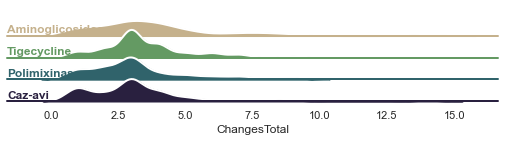

In [232]:
import pandas as pd

gg = [len(value) for value in res["Days"]["Total"].values()]

msg = []
for g, group in zip(gg, res["Days"]["Total"]):
    msg += [group] * g

data = pd.DataFrame({"Group" : msg,
                     "DaysTotal" : [i for value in res["Days"]["Total"].values() for i in value],
                     "DaysPrev" : [i for value in res["Days"]["Prev"].values() for i in value],
                     "DaysPost" : [i for value in res["Days"]["Post"].values() for i in value],
                     "ChangesTotal" : [i for value in res["Changes"]["Total"].values() for i in value],
                     "ChangesPrev" : [i for value in res["Changes"]["Prev"].values() for i in value],
                     "ChangesPost" : [i for value in res["Changes"]["Post"].values() for i in value]})

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


pal = sns.cubehelix_palette(4, rot=-6.5, light=.7)
g = sns.FacetGrid(data, row="Group", hue="Group", aspect=15, height=.5, palette=pal)

main = "ChangesTotal"

g.map(sns.kdeplot, main,
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, main, clip_on=False, color="w", lw=2, bw_adjust=.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, main)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [204]:
a = ['Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi', 'Caz-avi']

len(a)

84